# 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive
%cd ANDL_HOMEWORK1_LINK

Mounted at /gdrive
/gdrive/My Drive
/gdrive/.shortcut-targets-by-id/14RasmCIKqhEPRMZcyNhd3qdplUPJ-lAw/Homework 1


# ⚙️ Import Libraries

In [2]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os
import psutil

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np
import pandas as pd

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns

from tensorflow.keras import layers, models

from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.preprocessing.image import ImageDataGenerator


2.17.1


# ⏳ Load the Data

In [3]:
# Load the NPZ file
data = np.load('dataset/cleaned_dataset.npz',allow_pickle=True)

# Print the keys in the file to see what arrays are stored
print("Keys in the npz file:", data.files)

#Store Data in Arrays
images_data = data['images'] / 255
labels_data = data['labels']

print("Number of Images :",len(images_data))
print("Labels :",len(labels_data))

print("Shape of Images Array :", images_data.shape)
print("Shape of Labels Array :", labels_data.shape)


Keys in the npz file: ['images', 'labels']
Number of Images : 11959
Labels : 11959
Shape of Images Array : (11959, 96, 96, 3)
Shape of Labels Array : (11959, 1)


# ➗ Splitting dataset

In [4]:
###WE CAN MODIFY THE SPLIT COEFFICIANT....

# First split: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(images_data, labels_data, test_size=0.2, random_state=42, stratify=labels_data)

# Second split: Split the training set into 80% training and 20% validation (this means 64% train, 16% val overall)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

'''
Other types of splitting.

#KFold split
kf = KFold(n_splits=5, shuffle=False, random_state=42)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


#StratifiedKFold split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


#StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

#LeaveOneOut split
loo = LeaveOneOut()
for train_index, test_index in loo.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
'''

# Display the shapes of the resulting sets
print(f"X_train shape: {X_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (7653, 96, 96, 3)
X_val shape: (1914, 96, 96, 3)
X_test shape: (2392, 96, 96, 3)
y_train shape: (7653, 1)
y_val shape: (1914, 1)
y_test shape: (2392, 1)


# 👾 Model

In [5]:
# Define input shape, output shape, batch size, and number of epochs
input_shape = X_train.shape[1:]
output_shape = 8
batch_size = 16
epochs = 10
fine_tune_epochs = 10


In [6]:

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True, mode='auto'),
]


# Define a simple CNN model (same as before)
model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(8, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

### 🛠️ Train

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - accuracy: 0.5187 - loss: 1.3066 - val_accuracy: 0.8103 - val_loss: 0.5239
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8287 - loss: 0.4755 - val_accuracy: 0.8610 - val_loss: 0.4078
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.8711 - loss: 0.3538 - val_accuracy: 0.9206 - val_loss: 0.2286
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.9064 - loss: 0.2633 - val_accuracy: 0.9248 - val_loss: 0.2164
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9152 - loss: 0.2481 - val_accuracy: 0.9342 - val_loss: 0.1953
Epoch 6/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.9263 - loss: 0.1993 - val_accuracy: 0.9394 - val_loss: 0.2084
Epoch 7/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9354 - loss: 0.1846 - val_accuracy: 0.9289 - val_loss: 0.2280
Epoch 8/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.9467 - loss: 0.1541 - val_acc

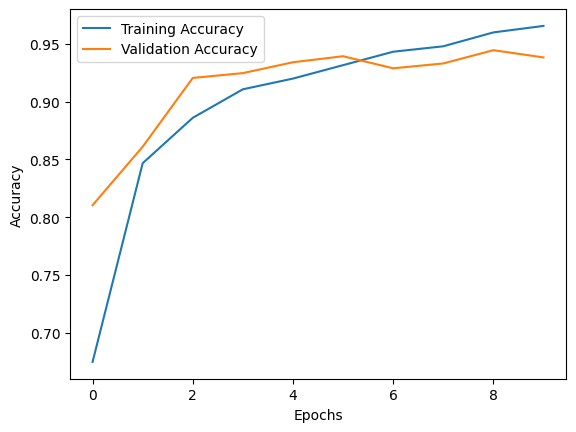

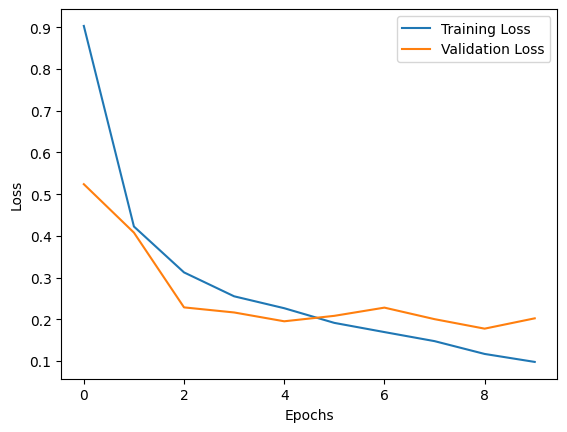

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9385 - loss: 0.2020
Test accuracy: 0.9393812417984009


In [7]:
# Train
history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val))

print(history.history)

# Plotting training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Once training is complete, evaluate the model on X_test (held-out test set)
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy}")


### ⏬ Save

In [8]:
model.save('very_simple_conv.keras')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,198,426 (19.83 MB)

 Trainable params: 1,732,808 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,465,618 (13.22 MB)